<a href="https://colab.research.google.com/github/dmbk/Anomaly-Detection-System/blob/master/TEST_AAE_ROC_test_Avenue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install imageio
!pip install qpsolvers
!pip install shapely 
#!pip install tensorflow_datasets
!pip install keras-layer-normalization
from google.colab import drive
#!pip install alive-progress
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:


from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import skimage
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from os.path import join
from os import listdir
from os.path import isfile, join, isdir

#import keras
import argparse
from os.path import dirname
import cv2
from google.colab.patches import cv2_imshow
	
import statistics
import shutil

import matplotlib.pyplot as plt

import time
#from progress.bar import IncrementalBar

import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, Dropout, Activation, InputLayer
from keras.optimizers import Adam
from keras_layer_normalization import LayerNormalization
from keras.models import load_model
import csv
from scipy.interpolate import make_interp_spline, BSpline

from scipy.signal import savgol_filter

Using TensorFlow backend.


In [0]:
def prepend_10_clips(test_case):
    
    test_aug = np.zeros(shape=(test_case.shape[0]+10, 256, 256, 1))
    #print(test_aug.shape)
    print(test_case.shape)
    for i in range(0,10):
        test_aug[2*i] = test_case[i]
        test_aug[2*i+1] = test_case[i]


    test_aug[20:] = test_case[10:]
    print("Appended test")
    print(test_aug.shape)
    return test_aug



def cap_video(file_path):

    cap = cv2.VideoCapture(file_path)
    if (cap.isOpened()== False):
        print("Error opening video stream or file")

    frames = []
    count = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        count = count +1
        if count%10 != 0:
            continue
        if ret == True:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.resize(frame, (256, 256))
            frame = np.array(frame, dtype=np.float32) / 256.0
            frames.append(frame)
        else: 
            break
    cap.release()
    cv2.destroyAllWindows()
    return frames

def get_video_list():
    return  [join(conf.DATASET_PATH, x) for x in sorted(listdir(conf.DATASET_PATH))]
        

def get_clips_list_from_video(seq_size):

    clips = []
    for f in get_video_list():
        print("Loading video "+f)
        all_frames = []
        if(os.path.isfile(f)):
            all_frames = cap_video(f) 
            print(np.array(all_frames).shape)
        for stride in range(1, 2):
            strided = get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=seq_size)
            #print(np.array(strided).shape)
            clips.extend(strided)

    return np.array(clips, dtype=np.float32)


def get_single_test_from_video(test_case):
    test = np.array(cap_video(join(conf.TEST_DIR,test_case)))
    test = np.resize(test, (test.shape[0], conf.dim2, conf.dim3, conf.dim4))
    test = prepend_10_clips(np.array(test))

    return test


def get_test_sequences_from_video(test_case):
    test = np.array(cap_video(join(conf.TEST_DIR,test_case)))
    test = np.resize(test, (test.shape[0], conf.dim2, conf.dim3, conf.dim4))
    test = prepend_10_clips(np.array(test))
    print("Test case loaded")
    sz = test.shape[0] - conf.dim1
    sequences = np.zeros((sz, conf.dim1, conf.dim2, conf.dim3, conf.dim4))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((conf.dim1, conf.dim2, conf.dim3, conf.dim4))
        for j in range(0, conf.dim1):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip
    return np.array(sequences)



def get_single_test(single_test_path, jpg = 0):
    
    sz = 0
    ext = "tif"
    if jpg == 1:
        ext = "jpg"
    for f in sorted(listdir(single_test_path)):
        if str(join(single_test_path, f))[-3:] == ext:
          sz = sz +1
    test = np.zeros(shape=(sz, conf.dim2, conf.dim3, conf.dim4))
    cnt = 0
    for f in sorted(listdir(single_test_path)):
        if str(join(single_test_path, f))[-3:] == ext:
            #print("img path: "+join(single_test_path, f))
            img = Image.open(join(single_test_path, f)).resize((conf.dim2, conf.dim3))
            #cv2_imshow(np.array(img,dtype=np.float32))
            #cv2.waitKey(0)
            img = np.array(img, dtype=np.float32) / 256
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    #print(np.array(test).shape)
    
    return prepend_10_clips(np.array(test))

def get_test_sequences(test_case_dir, jpg=0):
    test = get_single_test(join(conf.TEST_DIR,test_case_dir), jpg)
    print(np.array(test).shape)
    print("Test case loaded")
    sz = test.shape[0] - conf.dim1
    sequences = np.zeros((sz, conf.dim1, conf.dim2, conf.dim3, conf.dim4))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((conf.dim1, conf.dim2, conf.dim3, conf.dim4))
        for j in range(0, conf.dim1):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip
    return sequences





In [0]:
class Config:
    def __init__(self, data_dir_, cwdir_name_, data_set):
        self.data_set_name = data_set
        self.data_dir = data_dir_
        self.data_set_dir = join(self.data_dir, data_set)
        self.cwdir_name = cwdir_name_
        self.cwdir = join(self.data_dir,self.cwdir_name)
        self.run_data = join(self.cwdir, "training_dir")
        self.image_dir = join(self.run_data,self.data_set_name,"Test/")
        if not os.path.exists(self.cwdir):
            os.mkdir(self.cwdir)
            os.mkdir(self.run_data)
    
        if not os.path.exists(self.run_data):
            #shutil.rmtree(self.run_data)
            os.mkdir(self.run_data)
            os.makedirs(self.image_dir, exist_ok=True)

        self.DATASET_PATH = join(self.data_set_dir,"Train/")
        self.TEST_DIR = join(self.data_set_dir,"testing_videos/")
        self.BATCH_SIZE = 2
        self.EPOCHS = 50
        self.GEN_MODEL_PATH = join(self.cwdir,"model_gen_Conv2DLSTM_AAE")
        self.DIS_MODEL_PATH = join(self.cwdir,"model_dis_Conv2DLSTM_AAE")
        self.DEC_MODEL_PATH = join(self.cwdir,"model_dec_Conv2DLSTM_AAE")

        self.retrain = 0
        self.dim1 = 10
        self.dim2 = 256
        self.dim3 = 256
        self.dim4 = 1
        self.latent_dim = 327680


    def reconfig(self, new_name, batch_size = 4, epochs = 5, retrain = 0):
        self.cwdir_name = new_name
        self.cwdir = join(self.data_dir, self.cwdir_name)
        self.run_data = join(self.cwdir, "training_dir")
        self.image_dir = join(self.run_data,self.data_set_name,"testing_videos/")

        self.BATCH_SIZE = batch_size
        self.EPOCHS = epochs
        self.GEN_MODEL_PATH = join(self.cwdir,"model_gen_Conv2DLSTM_AAE")
        self.DIS_MODEL_PATH = join(self.cwdir,"model_dis_Conv2DLSTM_AAE")
        self.DEC_MODEL_PATH = join(self.cwdir,"model_dec_Conv2DLSTM_AAE")

        self.retrain = retrain
        if retrain == 0:
            print("Configuring train from scratch")
            if not os.path.exists(self.cwdir):
                os.mkdir(self.cwdir)
                os.mkdir(self.run_data)
    
            if os.path.exists(self.run_data):
                shutil.rmtree(self.run_data)
                os.mkdir(self.run_data)
                os.makedirs(self.image_dir, exist_ok=True)


conf = Config(data_dir_="/content/drive/My Drive/", cwdir_name_="Conv2DLSTM_AAE_Avenue_Enhanced", data_set="AVDT_TEST/") 


In [0]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/content/drive/My Drive/Persistence1D/python')


import matplotlib.pyplot as plt
import numpy as np
from persistence1d import RunPersistence
from reconstruct1d import RunReconstruction
import math    

from shapely.geometry import LineString

In [0]:
TestVideoFile_ped1 = list((36,2))
end = 200
#TestVideoFile_ped1_ori = [[60,152], [50,175], [91,end], [31,168], [5,90], [1,100], [1,175], [1,94], [1,48], [1,140],   [70,165],   [130,end],   [1,156],   [1,end],   [138,end],   [123,end],   [1,47],   [54,120],    [64,138],    [45,175],    [31,end],    [16,107],    [8,165],    [50,171],    [40,135],    [77,144],    [10,122],    [105,end],    [1,15],    [175,end],    [1,180],    [1,52],  [5,165],    [1,121],    [86,end],   [15,108]]


TestVideoFile_ped1 = [[60,152], [50,175], [91,end], [1,168], [5,139], [1,100], [1,175], [1,94], [1,48], [1,140],   [115,end],   [130,end],   [1,156],   [1,end],   [138,end],   [50, 60],   [1,47],   [54,120],    [64,138],    [45,175],    [31,end],    [16,107],    [8,end],    [1,171],    [40,135],    [77,end],    [10,122],    [105,end],    [1,15],    [175,end],    [1,180],    [1,52],  [1,175],    [1,121],    [86,end],   [15,108]]

TestVideoFile = []
TestVideoFile_avn = list((21,2))
TestVideoFile_avn = [[[36, 60],	[245, 350],	[433, 455],	[465, 575],	[680, 719]], [[137, 160],	[362, 382],	[569, 605]] ,[[147, 170],	[291, 312]]		,[[190, 213],	[324, 347]]		,[[232, 393]]			,[[175, 314],	[415, 506]]		,[[145, 302]]			,[[1, 18]]			,[[61, 135],	[243, 283],	[263, 400],	[435, 587]],[[284, 420]]		,[[1, 110],	[137, 179]]		,[[267, 466],	[270, 425]]		,[[220, 274]]			,[[197, 253]]			,[[232, 297]]			,[[278, 370]]			,[[1, 213]]			,[[1, 147]]			,[[1, 124]]			,[[1, 136]]			,[[1, 34]]			
]

avn_end_arr =  [719, 605, 461, 473, 503, 641, 302, 18, 587, 420, 236, 635, 274, 253, 500, 370, 213, 147, 124, 136, 38]

def SortExtremaByPersistence(ExtremaAndPersistence):
    #~ Sort the list of extrema by persistence.
    #~ The original list from RunPersistence() is not guaranteed to be sorted,
    #~ although it may appear sorted in many cases.
    #~ This call to sorted() creates a new list. If you want to sort in-place, use ExtremaAndPersistence.sort()
    SortedExtremaAndPersistence = sorted(ExtremaAndPersistence, key=lambda ExtremumAndPersistence: ExtremumAndPersistence[0])
    return SortedExtremaAndPersistence

def GetMinima(ExtremaAndPersistence):
    Minima = [t for t in ExtremaAndPersistence[::2]]
    return Minima

def GetMaxima(ExtremaAndPersistence):
    Maxima = [t for t in ExtremaAndPersistence[1::2]]
    return Maxima


def GetIntersection(x, f, g):

    plt.plot(x, f)
    plt.plot(x, g)

    first_line = LineString(np.column_stack((x, f)))
    second_line = LineString(np.column_stack((x, g)))
    intersection = first_line.intersection(second_line)
    print("Intersection")
    #print(intersection)
    x_list = []
    if intersection.geom_type == 'MultiPoint':
        plt.plot(*LineString(intersection).xy, 'o')
        print("Multipoint")
        print(*LineString(intersection).xy[0])
        for x_point in LineString(intersection).xy[0]:
            x_list.append(x_point)
    elif intersection.geom_type == 'Point':
        plt.plot(*intersection.xy, 'o')
        print("Point")
        print(*intersection.xy[0])
        x_list.append(*intersection.xy[0])

    x_arr = np.array(x_list)
    #print("X_LIST")
    #print(x_arr)
    return x_arr
    #all(i >= 30 for i in g[])

def find_overlap_rate(reference, detection):

    overlap = 0
    for x, y in detection:

        print("Intersect x, y   =   "+str(x)+" , "+str(y))
        for p, q in reference:
            print("Reference p, q   =   "+str(p)+" , "+str(q))
            if y > p and x < q:
                overlap = overlap+ abs(min(y,q) - max(x,p))

    print("Overlap: "+str(overlap))

    return overlap


def persistence(InputData, dt, id, color):
    if(dt == 3):
        end = avn_end_arr[id-1]
        TestVideoFile = TestVideoFile_avn
    #~ Compute the extrema of the given data and their persistence.
    ExtremaAndPersistence = RunPersistence(InputData)

    #~ Keep only those extrema with a persistence larger than 0.5.
    FilteredIndices = [t[0] for t in ExtremaAndPersistence if t[1] >= 0.1]

    #~ This simple call is all you need to reconstruct a smooth function containing only the filtered extrema
    SmoothData = RunReconstruction(InputData, FilteredIndices, 'biharmonic', 0.0000001)
    #print("Smooth data ")
    #print(SmoothData)

    x = np.array([x for x in range(0, InputData.shape[0])])
    
    g = SmoothData
    

    ##add gt_tuples : TODO
    
    #print(intersections)
    #~ Plot original and smoothed data
    fig, ax = plt.subplots()
    ax.plot(range(0, len(InputData)), InputData, label="Original Data", color="blue")
    ax.plot(range(0, len(SmoothData)), SmoothData, label="Smooth Data", color="red")
    ExtremaIndices = [t[0] for t in ExtremaAndPersistence]
    
    """
    sorted_extr = SortExtremaByPersistence(ExtremaAndPersistence)
    minima = SortExtremaByPersistence(GetMinima(ExtremaAndPersistence))
    maxima = SortExtremaByPersistence(GetMaxima(ExtremaAndPersistence))
    print("###########Print All Extremas#################")

  
    print([t for t in ExtremaAndPersistence])

    print("###########Print Filtered Extremas#################")

    print([t for t in FilteredIndices])

    print("###########Print Sorted Extremas#################")

    print([t for t in sorted_extr])

    print("###########Print Minimas#################")

    print([t for t in minima])

    print("###########Print Maximas#################")

    print([t for t in maxima])
    """


    gt_tuples = []
    ax.plot(ExtremaIndices, InputData[ExtremaIndices], marker='.', linestyle='')
    ax.plot(FilteredIndices, InputData[FilteredIndices], marker='*', linestyle='')
    ax.set(xlabel='data index', ylabel='data value')
    #ax.set_aspect(1.0/ax.get_data_ratio()*0.2)
    if dt == 3:
        for tvf in TestVideoFile[id-1]:
            plt.axvspan(tvf[0]-1, tvf[1]-1, alpha=0.5, color=color)
            #plt.axhline(y=threshold_abs,linewidth=1, color='blue') 
            gt_tuples.append((tvf[0]-1, tvf[1]-1))                
    if(dt == 1):
        plt.axvspan(TestVideoFile_ped1[id-1][0]-1, TestVideoFile_ped1[id-1][1]-1, alpha=0.5, color=color)
        #plt.axhline(y=threshold_abs,linewidth=1, color='blue') 
        gt_tuples.append((TestVideoFile_ped1[id-1][0]-1, TestVideoFile_ped1[id-1][1]-1))

    if dt == 1 and id == 5:
        plt.axvspan(140-1, end-1, alpha=0.5, color=color)
        gt_tuples.append((140-1, end-1))
    elif dt == 1 and id == 6:
        plt.axvspan(110-1, end-1, alpha=0.5, color=color) 
        gt_tuples.append((110-1, end-1))
    if dt == 1 and id == 8:
        plt.axvspan(150-1, end-1, alpha=0.5, color=color)
        gt_tuples.append((150-1, end-1))
    if dt == 1 and id == 16:
        plt.axvspan(123-1, end-1, alpha=0.5, color=color)
        gt_tuples.append((123-1, end-1))
    if dt == 1 and id == 18:
        plt.axvspan(160-1, 195-1, alpha=0.5, color=color)
        gt_tuples.append((160-1, 195-1))
    if dt == 1 and id == 22:
        plt.axvspan(172-1, end-1, alpha=0.5, color=color)
        gt_tuples.append((172-1, end-1))
    elif dt == 1 and id == 29:
        plt.axvspan(45-1, 113-1, alpha=0.5, color=color)
        gt_tuples.append((45-1, 113-1))
    elif dt == 1 and id == 32:
        plt.axvspan(65-1, 115-1, alpha=0.5, color=color)
        gt_tuples.append((65-1, 115-1))

    gt_inverse_tuples = []

    gti_start = 0
    for p, q in gt_tuples:
        if(p == gti_start):
            gti_start = q
            continue
        gt_inverse_tuples.append((gti_start, p))
        gti_start = q

    if gti_start < end-1:
        gt_inverse_tuples.append((gti_start, end-1))

    print("GT Tuples: "+str(gt_tuples))
    print("GT Inverse Tuples: "+str(gt_inverse_tuples))

    TPR_ARR = []
    FPR_ARR = []

    for threshold_abs in np.arange(0.4, 1.05, 0.05):
        f = np.ones(x.shape[0])*threshold_abs
        intersections = [0]
        intersections.extend(GetIntersection(x, f, g))
        if(intersections[len(intersections)-1] < end -1):
            intersections.extend([end-1])

        intersections = np.array(intersections)
        all_below_th = []
        #all_above_th = []

        for j, __ in enumerate(intersections):
            print("j : "+str(intersections[j]))
            print("j+1 : "+str(intersections[j+1]))
            
            if all(i <= threshold_abs for i in g[math.ceil(intersections[j]): math.floor(intersections[j+1])]):
                all_below_th.append((intersections[j], intersections[j+1]))
                
            if(end - 1 == math.floor(intersections[j+1])):
                break
            #if all(i >= threshold_abs for i in g[math.ceil(intersections[j]): math.floor(intersections[j+1])]):
            #    all_above_th.append((intersections[j], intersections[j+1]))

        print("_________Find TPR FPR for Threshold : "+str(threshold_abs)+"__________")
        print("============Find TPR============")
        TPR = find_overlap_rate(gt_tuples, all_below_th)
        print("============Find FPR============")
        FPR = find_overlap_rate(gt_inverse_tuples, all_below_th)

        TPR_ARR.append(TPR)
        FPR_ARR.append(FPR)
    
        print("TPR : "+str(TPR))
        print("FPR : "+str(FPR))
        print("\n\n\n")
    
    total_ref_gt = 0
    for p, q in gt_tuples:
        total_ref_gt = total_ref_gt+ abs(q-p)
    print("Total GT: "+str(total_ref_gt))
    total_ref_gti = 0
    for p, q in gt_inverse_tuples:
        total_ref_gti = total_ref_gti+ abs(q-p)
    print("Total GT Inv: "+str(total_ref_gti))

    ax.grid()
    #ax.plot()

    plt.legend()    
    plt.show()

    return TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti

threshold = 0.9
def fill_gt_ped1(sr, id, color):
    #plt.xlim((conf.dim1,len(sr)+conf.dim1))
    sr = np.reshape(sr, (sr.shape[0],))
    print(sr.shape)
    #zeros = np.zeros((conf.dim1,))
    #print(zeros.shape)
    #plt.plot(np.concatenate((zeros, sr)))
    #persistence(sr, 1, id, color)
    #yhat = savgol_filter(sr, 51, 3)
    #TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = persistence(yhat, 1, id, color)
    TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = persistence(sr, 1, id, color)
    #plt.plot(sr)  
    return TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti



TestVideoFile_ped2 = list((12,2))
TestVideoFile_ped2 = [[61,180],[95,180],[1,146],[31,180],[1,129],[1,159],[46,180],[1,180],[1,120],[1,150],[1,180],[88,180]]

def fill_gt_ped2(sr, id, color):
    #plt.xlim((conf.dim1,len(sr)+conf.dim1))
    sr = np.reshape(sr, (sr.shape[0],))
    #plt.plot(np.concatenate((np.zeros((conf.dim1,)), sr)))
    persistence(sr, 2, id, color)
    yhat = savgol_filter(sr, 51, 3)
    TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = persistence(yhat, 2, id, color)
    return TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti


def fill_gt_av(sr, id, color):
    #plt.xlim((conf.dim1,len(sr)+conf.dim1))
    sr = np.reshape(sr, (sr.shape[0],))
    print(sr.shape)
    #zeros = np.zeros((conf.dim1,))
    #print(zeros.shape)
    #plt.plot(np.concatenate((zeros, sr)))
    #persistence(sr, 1, id, color)
    #yhat = savgol_filter(sr, 51, 3)
    #TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = persistence(yhat, 1, id, color)
    TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = persistence(sr, 3, id, color)
    #plt.plot(sr)  
    return TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti




/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_26 (TimeDis (None, 10, 64, 64, 128)   15616     
_________________________________________________________________
layer_normalization_37 (Laye (None, 10, 64, 64, 128)   256       
_________________________________________________________________
time_distributed_27 (TimeDis (None, 10, 32, 32, 64)    204864    
_________________________________________________________________
layer_normalization_38 (Laye (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_19 (ConvLSTM2D) (None, 10, 32, 32, 64)    295168    
_________________________________________________________________
layer_normalization_39 (Laye (None, 10, 32, 32, 64)    128       
_________________________________________________________________
conv_lst_m2d_20 (ConvLSTM2D) (None, 10, 32, 32, 64)  

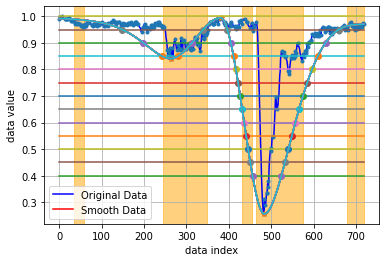

(605, 256, 256, 1)
Appended test
(615, 256, 256, 1)
(615, 256, 256, 1)
Test case loaded
Test cases shape: (605, 10, 256, 256, 1)
Test002 data set loaded
==============Without BG Masked==============
(605,)
GT Tuples: [(136, 159), (361, 381), (568, 604)]
GT Inverse Tuples: [(0, 136), (159, 361), (381, 568)]
Intersection
j : 0
j+1 : 604
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 604
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 604
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 604
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 

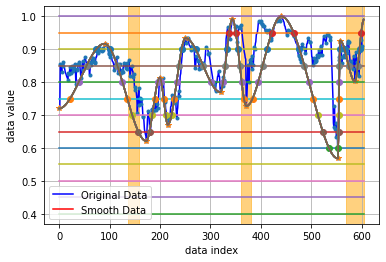

(461, 256, 256, 1)
Appended test
(471, 256, 256, 1)
(471, 256, 256, 1)
Test case loaded
Test cases shape: (461, 10, 256, 256, 1)
Test003 data set loaded
==============Without BG Masked==============
(461,)
GT Tuples: [(146, 169), (290, 311)]
GT Inverse Tuples: [(0, 146), (169, 290), (311, 460)]
Intersection
j : 0
j+1 : 460
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 460
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 460
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 460
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
==========

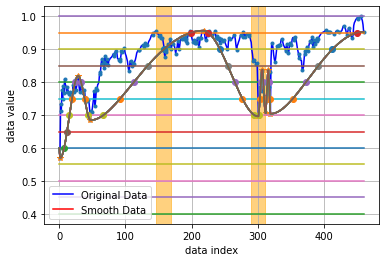

(473, 256, 256, 1)
Appended test
(483, 256, 256, 1)
(483, 256, 256, 1)
Test case loaded
Test cases shape: (473, 10, 256, 256, 1)
Test004 data set loaded
==============Without BG Masked==============
(473,)
GT Tuples: [(189, 212), (323, 346)]
GT Inverse Tuples: [(0, 189), (212, 323), (346, 472)]
Intersection
j : 0
j+1 : 472
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 472
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 472
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 472
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
==========

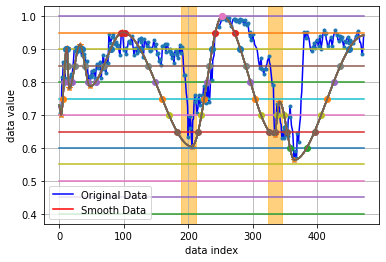

(503, 256, 256, 1)
Appended test
(513, 256, 256, 1)
(513, 256, 256, 1)
Test case loaded
Test cases shape: (503, 10, 256, 256, 1)
Test005 data set loaded
==============Without BG Masked==============
(503,)
GT Tuples: [(231, 392)]
GT Inverse Tuples: [(0, 231), (392, 502)]
Intersection
Multipoint
357.5314064899193 362.8077917783462 392.54147071526364 410.99813098047815
j : 0.0
j+1 : 357.5314064899193
j : 357.5314064899193
j+1 : 362.8077917783462
j : 362.8077917783462
j+1 : 392.54147071526364
j : 392.54147071526364
j+1 : 410.99813098047815
j : 410.99813098047815
j+1 : 502.0
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Intersect x, y   =   357.5314064899193 , 362.8077917783462
Reference p, q   =   231 , 392
Intersect x, y   =   392.54147071526364 , 410.99813098047815
Reference p, q   =   231 , 392
Overlap: 5.276385288426923
============Find FPR============
Intersect x, y   =   357.5314064899193 , 362.8077917783462
Reference p, q   =   0 , 231
Referen

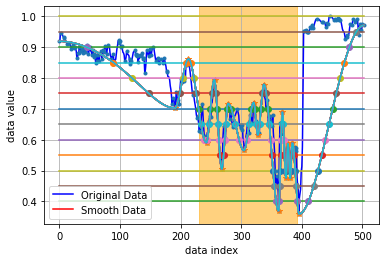

(641, 256, 256, 1)
Appended test
(651, 256, 256, 1)
(651, 256, 256, 1)
Test case loaded
Test cases shape: (641, 10, 256, 256, 1)
Test006 data set loaded
==============Without BG Masked==============
(641,)
GT Tuples: [(174, 313), (414, 505)]
GT Inverse Tuples: [(0, 174), (313, 414), (505, 640)]
Intersection
Multipoint
279.8381940279864 334.40902258218085
j : 0.0
j+1 : 279.8381940279864
j : 279.8381940279864
j+1 : 334.40902258218085
j : 334.40902258218085
j+1 : 640.0
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Intersect x, y   =   279.8381940279864 , 334.40902258218085
Reference p, q   =   174 , 313
Reference p, q   =   414 , 505
Overlap: 33.16180597201361
============Find FPR============
Intersect x, y   =   279.8381940279864 , 334.40902258218085
Reference p, q   =   0 , 174
Reference p, q   =   313 , 414
Reference p, q   =   505 , 640
Overlap: 21.409022582180853
TPR : 33.16180597201361
FPR : 21.409022582180853




Intersection
Multipoint
275.33

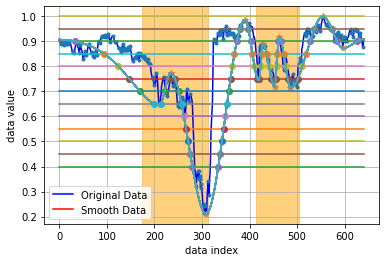

(302, 256, 256, 1)
Appended test
(312, 256, 256, 1)
(312, 256, 256, 1)
Test case loaded
Test cases shape: (302, 10, 256, 256, 1)
Test007 data set loaded
==============Without BG Masked==============
(302,)
GT Tuples: [(144, 301)]
GT Inverse Tuples: [(0, 144)]
Intersection
Multipoint
292.1592360690594 294.2100069151956
j : 0.0
j+1 : 292.1592360690594
j : 292.1592360690594
j+1 : 294.2100069151956
j : 294.2100069151956
j+1 : 301.0
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Intersect x, y   =   292.1592360690594 , 294.2100069151956
Reference p, q   =   144 , 301
Overlap: 2.0507708461362313
============Find FPR============
Intersect x, y   =   292.1592360690594 , 294.2100069151956
Reference p, q   =   0 , 144
Overlap: 0
TPR : 2.0507708461362313
FPR : 0




Intersection
Multipoint
242.98611260294734 244.05211901192973 286.68951138888673 297.12320687891105
j : 0.0
j+1 : 242.98611260294734
j : 242.98611260294734
j+1 : 244.05211901192973
j : 244.0521190

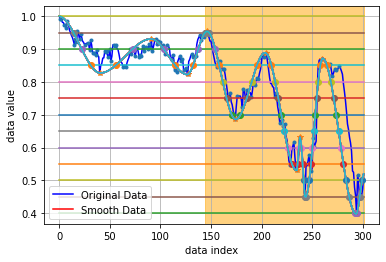

(18, 256, 256, 1)
Appended test
(28, 256, 256, 1)
(28, 256, 256, 1)
Test case loaded
Test cases shape: (18, 10, 256, 256, 1)
Test008 data set loaded
==============Without BG Masked==============
(18,)
GT Tuples: [(0, 17)]
GT Inverse Tuples: []
Intersection
j : 0
j+1 : 17
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 17
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 17
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 17
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




In

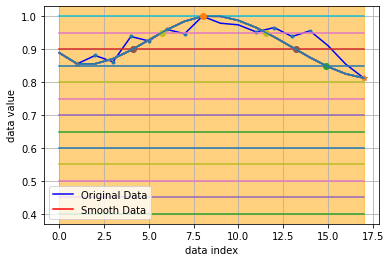

(587, 256, 256, 1)
Appended test
(597, 256, 256, 1)
(597, 256, 256, 1)
Test case loaded
Test cases shape: (587, 10, 256, 256, 1)
Test009 data set loaded
==============Without BG Masked==============
(587,)
GT Tuples: [(60, 134), (242, 282), (262, 399), (434, 586)]
GT Inverse Tuples: [(0, 60), (134, 242), (282, 262), (399, 434)]
Intersection
j : 0
j+1 : 586
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 586
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 586
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 586
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR

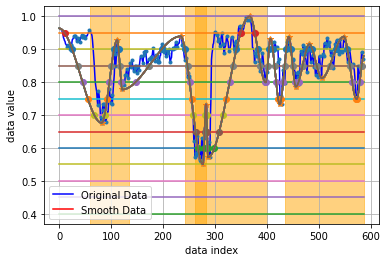

(420, 256, 256, 1)
Appended test
(430, 256, 256, 1)
(430, 256, 256, 1)
Test case loaded
Test cases shape: (420, 10, 256, 256, 1)
Test010 data set loaded
==============Without BG Masked==============
(420,)
GT Tuples: [(283, 419)]
GT Inverse Tuples: [(0, 283)]
Intersection
j : 0
j+1 : 419
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 419
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 419
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
Multipoint
47.0019779828967 61.99574116616873
j : 0.0
j+1 : 47.0019779828967
j : 47.0019779828967
j+1 : 61.99574116616873
j : 61.99574116616873
j+1 : 419.0
___

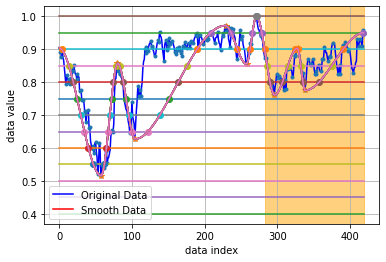

(236, 256, 256, 1)
Appended test
(246, 256, 256, 1)
(246, 256, 256, 1)
Test case loaded
Test cases shape: (236, 10, 256, 256, 1)
Test011 data set loaded
==============Without BG Masked==============
(236,)
GT Tuples: [(0, 109), (136, 178)]
GT Inverse Tuples: [(109, 136), (178, 235)]
Intersection
Multipoint
165.57371195025166 177.6215521695953
j : 0.0
j+1 : 165.57371195025166
j : 165.57371195025166
j+1 : 177.6215521695953
j : 177.6215521695953
j+1 : 235.0
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Intersect x, y   =   165.57371195025166 , 177.6215521695953
Reference p, q   =   0 , 109
Reference p, q   =   136 , 178
Overlap: 12.047840219343641
============Find FPR============
Intersect x, y   =   165.57371195025166 , 177.6215521695953
Reference p, q   =   109 , 136
Reference p, q   =   178 , 235
Overlap: 0
TPR : 12.047840219343641
FPR : 0




Intersection
Multipoint
160.8979548984354 184.3554375128806
j : 0.0
j+1 : 160.8979548984354
j : 160.89795

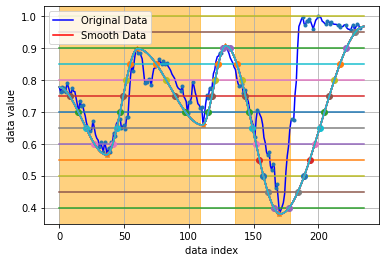

(635, 256, 256, 1)
Appended test
(645, 256, 256, 1)
(645, 256, 256, 1)
Test case loaded
Test cases shape: (635, 10, 256, 256, 1)
Test012 data set loaded
==============Without BG Masked==============
(635,)
GT Tuples: [(266, 465), (269, 424)]
GT Inverse Tuples: [(0, 266), (465, 269), (424, 634)]
Intersection
j : 0
j+1 : 634
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
Multipoint
502.2408235196386 510.27510128845074 536.8708206664658 540.2192039961197
j : 0.0
j+1 : 502.2408235196386
j : 502.2408235196386
j+1 : 510.27510128845074
j : 510.27510128845074
j+1 : 536.8708206664658
j : 536.8708206664658
j+1 : 540.2192039961197
j : 540.2192039961197
j+1 : 634.0
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Intersect x, y   =   502.2408235196386 , 510.27510128845074
Reference p, q   =   266 , 465
Reference p, q   =   269 , 424
Inte

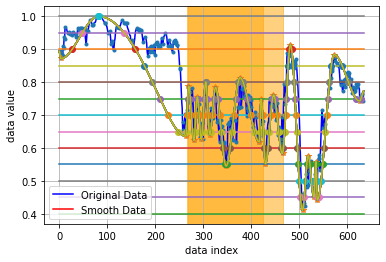

(274, 256, 256, 1)
Appended test
(284, 256, 256, 1)
(284, 256, 256, 1)
Test case loaded
Test cases shape: (274, 10, 256, 256, 1)
Test013 data set loaded
==============Without BG Masked==============
(274,)
GT Tuples: [(219, 273)]
GT Inverse Tuples: [(0, 219)]
Intersection
j : 0
j+1 : 273
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 273
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 273
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
Multipoint
235.5791140757298 256.0056832406408
j : 0.0
j+1 : 235.5791140757298
j : 235.5791140757298
j+1 : 256.0056832406408
j : 256.0056832406408
j+1 : 273.0


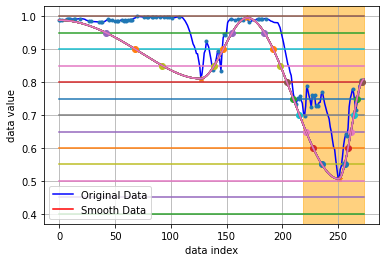

(253, 256, 256, 1)
Appended test
(263, 256, 256, 1)
(263, 256, 256, 1)
Test case loaded
Test cases shape: (253, 10, 256, 256, 1)
Test014 data set loaded
==============Without BG Masked==============
(253,)
GT Tuples: [(196, 252)]
GT Inverse Tuples: [(0, 196)]
Intersection
j : 0
j+1 : 252
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 252
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
Multipoint
162.8876425295985 166.23327377648422 188.68992403682145 193.63347274692617
j : 0.0
j+1 : 162.8876425295985
j : 162.8876425295985
j+1 : 166.23327377648422
j : 166.23327377648422
j+1 : 188.68992403682145
j : 188.68992403682145
j+1 : 193.63347274692617
j : 193.63347274692617
j+1 : 252.0
_________Find TPR FPR for Threshold : 0.5__________


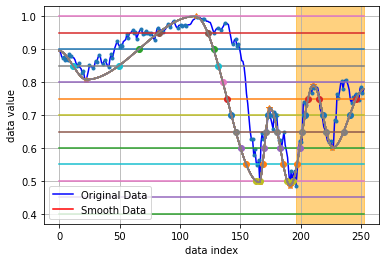

(500, 256, 256, 1)
Appended test
(510, 256, 256, 1)
(510, 256, 256, 1)
Test case loaded
Test cases shape: (500, 10, 256, 256, 1)
Test015 data set loaded
==============Without BG Masked==============
(500,)
GT Tuples: [(231, 296)]
GT Inverse Tuples: [(0, 231), (296, 499)]
Intersection
j : 0
j+1 : 499
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 499
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
Multipoint
274.2901299960346 303.72216288592335
j : 0.0
j+1 : 274.2901299960346
j : 274.2901299960346
j+1 : 303.72216288592335
j : 303.72216288592335
j+1 : 499.0
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Intersect x, y   =   274.2901299960346 , 303.72216288592335
Reference p, q   =   231 , 29

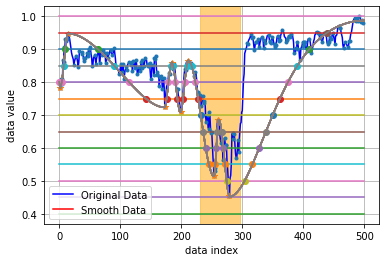

(370, 256, 256, 1)
Appended test
(380, 256, 256, 1)
(380, 256, 256, 1)
Test case loaded
Test cases shape: (370, 10, 256, 256, 1)
Test016 data set loaded
==============Without BG Masked==============
(370,)
GT Tuples: [(277, 369)]
GT Inverse Tuples: [(0, 277)]
Intersection
Point
361.7333812647855
j : 0.0
j+1 : 361.7333812647855
j : 361.7333812647855
j+1 : 369.0
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Intersect x, y   =   361.7333812647855 , 369.0
Reference p, q   =   277 , 369
Overlap: 7.266618735214479
============Find FPR============
Intersect x, y   =   361.7333812647855 , 369.0
Reference p, q   =   0 , 277
Overlap: 0
TPR : 7.266618735214479
FPR : 0




Intersection
Point
358.25097215313434
j : 0.0
j+1 : 358.25097215313434
j : 358.25097215313434
j+1 : 369.0
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Intersect x, y   =   358.25097215313434 , 369.0
Reference p, q   =   277 , 369
Overlap: 10.74902784

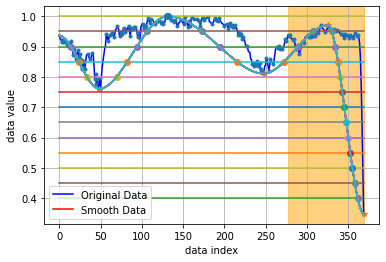

(213, 256, 256, 1)
Appended test
(223, 256, 256, 1)
(223, 256, 256, 1)
Test case loaded
Test cases shape: (213, 10, 256, 256, 1)
Test017 data set loaded
==============Without BG Masked==============
(213,)
GT Tuples: [(0, 212)]
GT Inverse Tuples: []
Intersection
j : 0
j+1 : 212
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 212
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 212
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 212
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR 

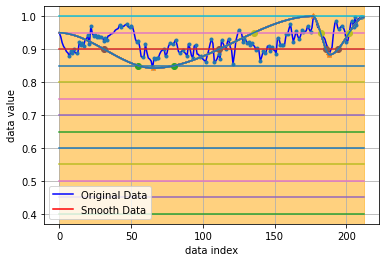

(147, 256, 256, 1)
Appended test
(157, 256, 256, 1)
(157, 256, 256, 1)
Test case loaded
Test cases shape: (147, 10, 256, 256, 1)
Test018 data set loaded
==============Without BG Masked==============
(147,)
GT Tuples: [(0, 146)]
GT Inverse Tuples: []
Intersection
j : 0
j+1 : 146
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 146
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 146
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 146
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR 

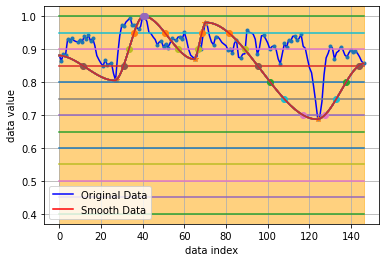

(124, 256, 256, 1)
Appended test
(134, 256, 256, 1)
(134, 256, 256, 1)
Test case loaded
Test cases shape: (124, 10, 256, 256, 1)
Test019 data set loaded
==============Without BG Masked==============
(124,)
GT Tuples: [(0, 123)]
GT Inverse Tuples: []
Intersection
j : 0
j+1 : 123
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 123
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 123
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
Multipoint
76.74472525578761 87.95910652764937
j : 0.0
j+1 : 76.74472525578761
j : 76.74472525578761
j+1 : 87.95910652764937
j : 87.95910652764937
j+1 : 123.0
_________F

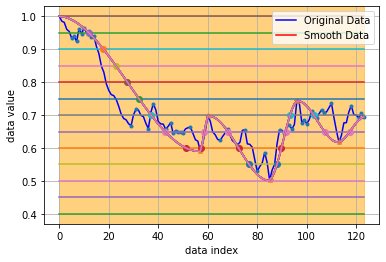

(136, 256, 256, 1)
Appended test
(146, 256, 256, 1)
(146, 256, 256, 1)
Test case loaded
Test cases shape: (136, 10, 256, 256, 1)
Test020 data set loaded
==============Without BG Masked==============
(136,)
GT Tuples: [(0, 135)]
GT Inverse Tuples: []
Intersection
j : 0
j+1 : 135
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 135
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 135
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 135
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR 

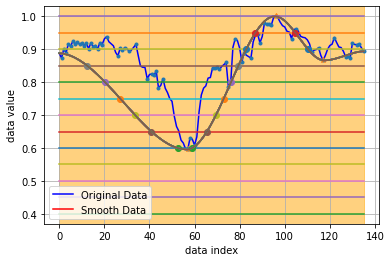

(38, 256, 256, 1)
Appended test
(48, 256, 256, 1)
(48, 256, 256, 1)
Test case loaded
Test cases shape: (38, 10, 256, 256, 1)
Test021 data set loaded
==============Without BG Masked==============
(38,)
GT Tuples: [(0, 33)]
GT Inverse Tuples: [(33, 37)]
Intersection
j : 0
j+1 : 37
_________Find TPR FPR for Threshold : 0.4__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 37
_________Find TPR FPR for Threshold : 0.45__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 37
_________Find TPR FPR for Threshold : 0.5__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 0




Intersection
j : 0
j+1 : 37
_________Find TPR FPR for Threshold : 0.55__________
============Find TPR============
Overlap: 0
============Find FPR============
Overlap: 0
TPR : 0
FPR : 

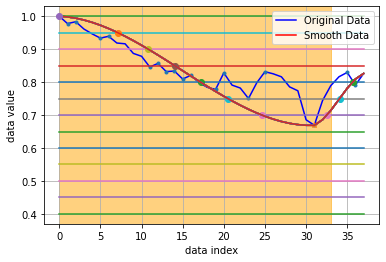

total_ref_gt_arr :[300, 79, 44, 46, 161, 230, 157, 17, 403, 136, 151, 354, 54, 56, 65, 92, 212, 146, 123, 135, 33]
total_ref_gti_arr :[418, 525, 416, 426, 341, 410, 144, 0, 223, 283, 84, 672, 219, 196, 434, 277, 0, 0, 0, 0, 4]

















































































































































































































































































[2994. 2994. 2994. 2994. 2994. 2994. 2994. 2994. 2994. 2994. 2994. 2994.
 2994.]
[5072. 5072. 5072. 5072. 5072. 5072. 5072. 5072. 5072. 5072. 5072. 5072.
 5072.]
(13,)
(13,)


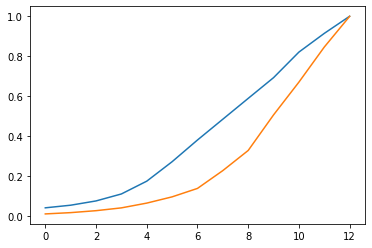

In [12]:
def build_model_aae():
  
    model_enc = load_model(conf.cwdir+"/model_gen_Conv2DLSTM_AAEep200",custom_objects={'LayerNormalization': LayerNormalization})
    model_dec = load_model(conf.cwdir+"/model_dec_Conv2DLSTM_AAEep200",custom_objects={'LayerNormalization': LayerNormalization})
    model_disc = load_model(conf.cwdir+"/model_dis_Conv2DLSTM_AAEep200",custom_objects={'LayerNormalization': LayerNormalization})

    #model_enc = load_model("/content/drive/My Drive/model_gen_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})
    #model_dec = load_model("/content/drive/My Drive/model_dec_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})
    #model_disc = load_model("/content/drive/My Drive/model_dis_Conv2DLSTM_AAEep100",custom_objects={'LayerNormalization': LayerNormalization})

    model_ae = Sequential()
    model_ae.add(model_enc)
    model_ae.add(model_dec)
    
    model_enc_disc = Sequential()
    model_enc_disc.add(model_enc)
    model_enc_disc.add(model_disc)
    
    return model_enc, model_dec, model_disc, model_ae, model_enc_disc

model_enc, model_dec, model_disc, model_ae, model_enc_disc = build_model_aae()

model_enc.summary()
model_dec.summary()
model_disc.summary()
model_ae.summary()
model_enc_disc.summary()

model_disc.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy")
model_enc_disc.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy")
model_ae.compile(optimizer=Adam(lr=1e-4, decay=1e-5, epsilon=1e-6), loss="mse")
#"/content/drive/My Drive/UCSD_Anomaly_Dataset.v1p2/model.hdf5"

#model_ae = load_model("/content/drive/My Drive/VAE/model1.hdf5",custom_objects={'LayerNormalization': LayerNormalization})

def evaluate_dis(sequences, model, id, dt):
    fooling_loss = model.predict(sequences,batch_size=conf.BATCH_SIZE)
    sa = (fooling_loss - np.min(fooling_loss)) / (np.max(fooling_loss))
    sr = 1.0 - sa

    with open(join("/content/drive/My Drive/", 'sr_score.csv'), mode='a') as f:
        writer = csv.writer(f)
        writer.writerow([float(x[0]) for x in sr])
        f.close()

    threshold_abs = threshold# np.min(sr)+ (np.max(sr) - np.min(sr)) * threshold
    if dt == 1:
        fill_gt_ped1(sr, id, 'red', threshold_abs)
    elif dt == 2:
        fill_gt_ped2(sr, id, 'red', threshold_abs)
    #plt.plot(sr)
    #plt.ylabel('regularity score sr_dis(t)')
    #plt.xlabel('frame t')
    #plt.show()

def get_clips(test):
    sz = test.shape[0] - conf.dim1
    sequences = np.zeros((sz, conf.dim1, conf.dim2, conf.dim3))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((conf.dim1, conf.dim2, conf.dim3))
        for j in range(0, conf.dim1):
            clip[j] = test[i + j, :, :]
        sequences[i] = clip
    return sequences


def mask_array(bg_list):

    for p in range(0, bg_list.shape[0]):
        for r in range(256):
            for c in range(256):
                if bg_list[p][r][c] > 0:
                    bg_list[p][r][c] = 1
                else:
                    bg_list[p][r][c] = 0

    bg_list[0, :, :] = 0
    return bg_list

def evaluate_ae(sequences, model, id, dt, bg_list=[], mask=1):
  
    sz = len(sequences)

    reconstructed_sequences = model.predict(sequences,batch_size=conf.BATCH_SIZE)
    #print(bg_list[10])


    sequences = np.reshape(sequences, (sequences.shape[0], sequences.shape[1], sequences.shape[2], sequences.shape[3]))
    reconstructed_sequences = np.reshape(reconstructed_sequences, (reconstructed_sequences.shape[0], reconstructed_sequences.shape[1], reconstructed_sequences.shape[2], reconstructed_sequences.shape[3]))

    if mask == 1:
        print("==============With BG Masked==============")
        masked_bg = mask_array(bg_list)
        bg_clips = get_clips(masked_bg)
    
        sq_masked = np.multiply(sequences, bg_clips)
        rec_masked = np.multiply(reconstructed_sequences, bg_clips)
    else:
        print("==============Without BG Masked==============")
        sq_masked = sequences
        rec_masked = reconstructed_sequences

    #bg_weights = np.add(np.ones(bg_clips.shape), bg_clips)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sq_masked[i], rec_masked[i])) for i in range(0,sz)])
    #sequences_reconstruction_cost = np.array([np.linalg.norm(np.multiply(bg_weights[i],np.subtract(sequences[i], reconstructed_sequences[i]))) for i in range(0,sz)])


    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / (np.max(sequences_reconstruction_cost))

    
    sr = 1 - sa
    #threshold_abs = threshold#np.min(sr)+ (np.max(sr) - np.min(sr)) * threshold
    if dt == 1:
        TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = fill_gt_ped1(sr, id, 'orange')
    elif dt == 2:
        TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = fill_gt_ped2(sr, id, 'orange')
    elif dt == 3:
        TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = fill_gt_av(sr, id, 'orange')
    #plt.plot(sr)
    #plt.ylabel('regularity score sr_ae(t)')
    #plt.xlabel('frame t')
    #plt.show()
    return TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti

def load_input_data_list():
    path = join("/content/drive/My Drive/", 'sr_score.csv')
    InputDataList = LoadData(path)
    return InputDataList


def get_persistance(InputData):
  #~ This simple call is all you need to compute the extrema of the given data and their persistence.
  ExtremaAndPersistence = RunPersistence(InputData)

  #~ Keep only those extrema with a persistence larger than 10.
  Filtered = [t for t in ExtremaAndPersistence if ExtremaAndPersistence[1] > 50]
  print(ExtremaAndPersistence)
  print(Filtered)
  #~ Sort the list of extrema by persistence.
  #Sorted = sorted(Filtered, key=lambda ExtremumAndPersistence: ExtremumAndPersistence[1])

  return Filtered


conf.reconfig(new_name="Conv2DLSTM_AAE_Avenue_Enhanced", batch_size=4, epochs=100, retrain=1)




def edge_detect(gray):
    edges1 = np.uint8(gray)
    # Using the Canny filter to get contours
    #edges = cv2.Canny(edges1, 20, 30)
    
    # Using the Canny filter with different parameters
    edges_high_thresh = cv2.Canny(edges1, 160, 200)
    kernel = np.zeros((5,5),np.uint8)
    kernel2 = np.zeros((2,2),np.uint8)

    images = cv2.morphologyEx(edges_high_thresh, cv2.MORPH_OPEN, kernel)
    images = cv2.morphologyEx(edges_high_thresh, cv2.MORPH_OPEN, kernel)
    images = cv2.morphologyEx(images, cv2.MORPH_CLOSE, kernel2)
    # Stacking the images to print them together
    # For comparison
    #images = np.hstack((gray, edges, edges_high_thresh))

    #kernel = np.ones((3,3), np.uint8) 
    #fg_mask = cv2.erode(edges_high_thresh, kernel, iterations=2)
    # Display the resulting frame
    #cv2_imshow(images)
    return images

    

def connected_comp(img):

    #find all your connected components (white blobs in your image)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)
    #connectedComponentswithStats yields every seperated component with information on each of them, such as size
    #the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
    sizes = stats[1:, -1]; nb_components = nb_components - 1

    # minimum size of particles we want to keep (number of pixels)
    #here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
    min_size = 10  

    #your answer image
    img2 = np.zeros((output.shape))
    #for every component in the image, you keep it only if it's above min_size
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            img2[output == i + 1] = 255
    return img2

def get_background_subtr(test_case):
    print("BGS show" + str(np.array(test_case).shape))

    subtractor = cv2.createBackgroundSubtractorMOG2(history=50, varThreshold=50, detectShadows=True)
    bg_list = []
    for frame in test_case:
        frame = np.reshape(frame, (256, 256))*256
        edge_mask = edge_detect(frame)
        bg_mask = connected_comp(edge_mask)
        #bg_mask = subtractor.apply(frame)
        #bg_mask = connected_comp(bg_mask)
        #bg_mask = edge_detect(bg_mask)
        #edge_mask[0] = np.zeros(edge_mask[0].shape)
        #kernel = np.ones((5,5), np.uint8) 
        #fg_mask = cv2.erode(mask, kernel, iterations=2)
        #fg_mask = cv2.dilate(fg_mask, kernel, iterations=5)
        fg_mask = bg_mask/255.0
        #fg_mask = mask
        #cv2_imshow(fg_mask)
        #print(fg_mask)
        bg_list.append(fg_mask)
        #key = cv2.waitKey(30)
        #if key == 27:
        #    break
    cv2_imshow(bg_list[100]*255.0)
    #cv2.destroyAllWindows()
    #print(bg_list)
    return np.array(bg_list)


def show_bgs(test_case_dir, jpg = 0):
    
    test = get_single_test(join(conf.TEST_DIR,test_case_dir), jpg)
    return get_background_subtr(test)


TPR_FOR_CASES = []
FPR_FOR_CASES = []
total_ref_gt_arr = []
total_ref_gti_arr = []
#print(bg_list[10])
jpg = 1
dt = 3
for i in range(1,22):
  if i < 10:
    img_num = "00"+str(i)
  elif i < 100:
    img_num = "0"+str(i)
  else:
    img_num = str(i) 

  #if img_num == "017":
  #  continue

 
  
  
  test_cases_dir = "Test"+str(img_num)
  bg_list = []
  #bg_list = show_bgs(test_cases_dir, jpg)

  test_cases = get_test_sequences(test_cases_dir, jpg)
  #test_cases = np.array(prepend_10_clips(test_cases))
  print("Test cases shape: "+str(np.array(test_cases).shape))
  print(str(test_cases_dir)+" data set loaded")
  #evaluate_dis(test_cases, model_enc_disc, i, 1)
  #sorted_sr = get_persistance(np.array([x[0] for x in sr_dis], dtype=float))
  #print(sorted_sr)
  #break
  TPR_ARR, FPR_ARR, total_ref_gt, total_ref_gti = evaluate_ae(test_cases, model_ae, i, dt, bg_list, 0)
  TPR_FOR_CASES.append(TPR_ARR)
  FPR_FOR_CASES.append(FPR_ARR)
  total_ref_gt_arr.append(total_ref_gt)
  total_ref_gti_arr.append(total_ref_gti)
  
  #evaluate_ae(test_cases, model_ae, i, 1, bg_list, 0)

  #sr_comb = (sr_dis + sr_ae)*0.5
  #sr_comb = []

  continue

print("total_ref_gt_arr :"+str(total_ref_gt_arr))
print("total_ref_gti_arr :"+str(total_ref_gti_arr))


TPR_FOR_CASES = np.array(TPR_FOR_CASES)
FPR_FOR_CASES = np.array(FPR_FOR_CASES)
i=0
j=0
TPR_ADD = np.zeros((TPR_FOR_CASES[0].shape[0],))
TP_REF_ADD = np.zeros(TPR_ADD.shape) 
for id, TPR_CASE in enumerate(TPR_FOR_CASES):

    for i, __ in enumerate(TPR_CASE):
        TPR_ADD[i] = TPR_ADD[i]+TPR_CASE[i]
        print()
        TP_REF_ADD[i] = TP_REF_ADD[i]+total_ref_gt_arr[id]


id=0

FPR_ADD = np.zeros((FPR_FOR_CASES[0].shape[0],))
FP_REF_ADD = np.zeros(FPR_ADD.shape) 
for id, FPR_CASE in enumerate(FPR_FOR_CASES):

    for j, __ in enumerate(FPR_CASE):
        FPR_ADD[j] = FPR_ADD[j]+FPR_CASE[j]
        FP_REF_ADD[j] = FP_REF_ADD[j]+total_ref_gti_arr[id]


print(TP_REF_ADD)
print(FP_REF_ADD)

TPR_PLOT = np.divide(TPR_ADD, TP_REF_ADD)
FPR_PLOT = np.divide(FPR_ADD, FP_REF_ADD)

print(TPR_PLOT.shape)
print(FPR_PLOT.shape)

plt.plot(TPR_PLOT)
plt.plot(FPR_PLOT)
plt.show()

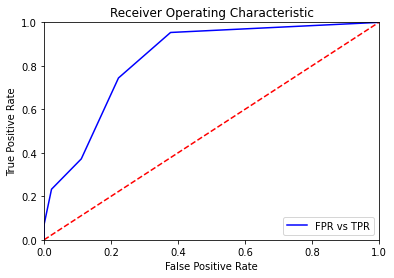

TPR
[0, 0, 0, 0, 0.069767441860465, 0.232558139534884, 0.372093023255814, 0.744186046511628, 0.953488372093023, 0.953488372093023, 1]
FPR
[0, 0, 0, 0, 0, 0.022222222222222, 0.111111111111111, 0.222222222222222, 0.377777777777778, 0.377777777777778, 1]
AUC = 0.8320413436692506


In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
TPR = [0,	0,	0,	0,	0.069767441860465,	0.232558139534884,	0.372093023255814,	0.744186046511628,	0.953488372093023,	0.953488372093023, 1]
FPR = [0,	0,	0,	0,	0,	0.022222222222222,	0.111111111111111,	0.222222222222222,	0.377777777777778,	0.377777777777778, 1]
plt.plot(FPR, TPR, 'b', label = "FPR vs TPR")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("TPR")
print(TPR)
print("FPR")
print(FPR)

def integrate(x, y):
    area = np.trapz(y=y, x=x, dx=0.05)
    return area


print("AUC = "+str(integrate(FPR, TPR)))

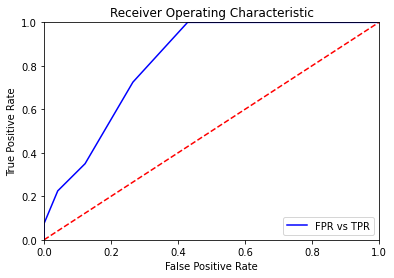

TPR
[0, 0, 0, 0, 0.075, 0.225, 0.35, 0.725, 1, 1, 1]
FPR
[0, 0, 0, 0, 0, 0.040816326530612, 0.122448979591837, 0.26530612244898, 0.428571428571429, 0.428571428571429, 1]
AUC = 0.8186224489795916


In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
TPR = [0,	0,	0,	0,	0.075,	0.225,	0.35,	0.725,	1,	1, 1]
FPR = [0,	0,	0,	0,	0,	0.040816326530612,	0.122448979591837,	0.26530612244898,	0.428571428571429,	0.428571428571429, 1]
plt.plot(FPR, TPR, 'b', label = "FPR vs TPR")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("TPR")
print(TPR)
print("FPR")
print(FPR)

def integrate(x, y):
    area = np.trapz(y=y, x=x, dx=0.05)
    return area


print("AUC = "+str(integrate(FPR, TPR)))

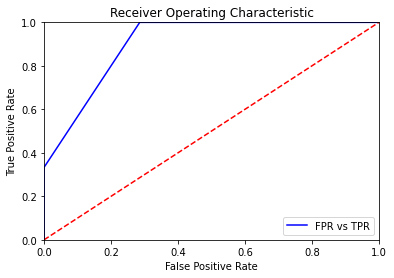

TPR
[0, 0, 0, 0, 0.083333333333333, 0.166666666666667, 0.333333333333333, 1, 1, 1, 1]
FPR
[0, 0, 0, 0, 0, 0, 0, 0.285714285714286, 0.714285714285714, 0.714285714285714, 1]
AUC = 0.9047619047619047


In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
TPR = [0,	0,	0,	0,	0.083333333333333,	0.166666666666667,	0.333333333333333,	1,	1,	1, 1]
FPR = [0,	0,	0,	0,	0,	0,	0,	0.285714285714286,	0.714285714285714,	0.714285714285714, 1]
plt.plot(FPR, TPR, 'b', label = "FPR vs TPR")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("TPR")
print(TPR)
print("FPR")
print(FPR)

def integrate(x, y):
    area = np.trapz(y=y, x=x, dx=0.05)
    return area


print("AUC = "+str(integrate(FPR, TPR)))